<font size=7>Instant Firing Rate -  Analysis

In this notebook we perform the instant firing rate analysis pipeline on the dataset `2023-04-02-e-hc328_unperturbed`. Specifically, the analysis is done on the curated form of the dataset, located in `/home/jovyan/work/Human_Hippocampus/StitchedDataUpdated.pkl`

<font color="red">

**To Do**
* Why original sttc value of pair i not in cross sttc values

# Set Up Notebook

Load source code

In [1]:
%run "workspaces/ Instant_Firing_Rate_Source_Code.ipynb"

Exception: File `'Instant_Firing_Rate_Source_Code.ipynb'` not found.

In [2]:
%run "read_phy_files.ipynb"

Exception: File `'read_phy_files.ipynb'` not found.

In [3]:
%run "/workspaces/human_hippocampus/dev/elliott/Latencies/Latencies_Source_Code.ipynb"

load data

In [4]:
import pickle
file = open('/workspaces/human_hippocampus/data/ephys/StitchedDataUpdated.pkl', 'rb')
sd = pickle.load(file)
file.close()

## <font color="blue"> crossSTTC function

In [8]:
def crossSTTC( n1, n2, sd, delt ):
    assert len(sd.neuron_attributes) == len(sd.train) 
    sttcs = []
    for i in range(-1000,1001):
        sd.train.append( sd.train[n1]+i )
        sttcs.append( sd.spike_time_tiling( len(sd.neuron_attributes) , n2, delt= delt) )
        sd.train.pop(-1)
    return np.array(sttcs)

# Get initial pairs

get all latencies whose STTC is above some minimum STTC cuttoff

In [9]:
sttc_neo = sd.spike_time_tilings()    # sttc matrix
sttc_cutoff = 0.04   

pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for i in range(sd.N):
    for j in range(i+1,sd.N):
        if sttc_neo[i,j] > sttc_cutoff:
            pairs.append([i,j])

In [10]:
len(pairs)

617

Get all latencies whose median latency is above 1 ms Latency Cuttoff

In [11]:
pairs_late = []
lags_late = []
for pair in pairs:
    latencies = getLatencies( pair[0], pair[1], sd, ms_cutoff=20)
    latency= np.median(latencies)
    if abs(latency)>1:
        pairs_late.append( pair )
        lags_late.append( latency )
pairs= pairs_late

In [12]:
len(pairs_late)

388

# Cross STTC - Attempt 1

do cross sttc for all pairs

In [13]:
cross_lag  = []
cross_sttc = []
cross_sttcs = []
count = 0
delta = 30
for pair in pairs_late:
    count+=1
    if count%20 ==0:
        print(count)
    sttcs = crossSTTC( pair[0], pair[1], sd, delt=delta)
    cross_sttcs.append(sttcs)
    cross_sttc.append( np.amax(sttcs) )
    max_args = np.argwhere(sttcs == np.amax(sttcs)) - 1000 
    cross_lag.append( max_args[np.argmin(np.abs(max_args))][0] )
cross_lag = np.array(cross_lag)

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


Get pairs where max cross correlation is between some cutoff

In [14]:
min_lag_cutoff = 2
max_lag_cutoff = 10
to_keep = np.where((np.abs(cross_lag)< max_lag_cutoff) & (np.abs(cross_lag)> min_lag_cutoff) & (cross_lag!=0) )[0]

In [15]:
to_keep

array([  0,   2,  37,  39,  52,  56,  60,  63,  83,  84,  86,  94, 101,
       103, 104, 107, 121, 148, 159, 164, 166, 180, 189, 194, 201, 207,
       240, 254, 264, 276, 277, 279, 284, 296, 297, 303, 328, 330, 331,
       339, 348, 381, 383, 386])

In [16]:
len(to_keep)

44

In [33]:
pairs_corr = np.array(pairs)[ to_keep ] 
lags_corr = np.array(cross_lag)[to_keep]
sttcs_corr = np.array(cross_sttcs)[to_keep]

In [34]:
import warnings
warnings.filterwarnings("ignore")

Delta: 30, Lag_Cutoff: 15


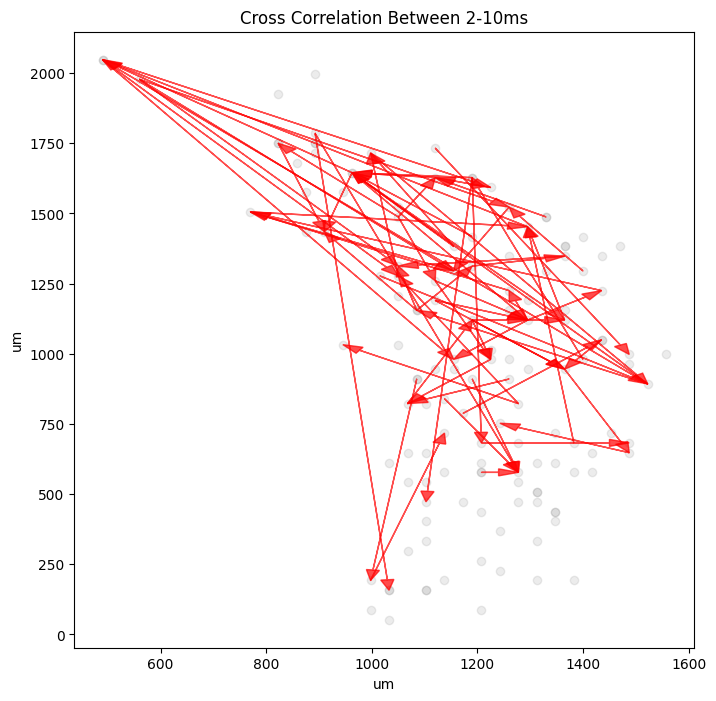

In [29]:
#print(f"Delta: 30, Lag_Cutoff: 10")
print(f"Delta: {delta}, Lag_Cutoff: {lag_cutoff}")
plotLagsLayout(sd, lags_corr, pairs_corr)


Delta: 30, Lag_Cutoff: 15


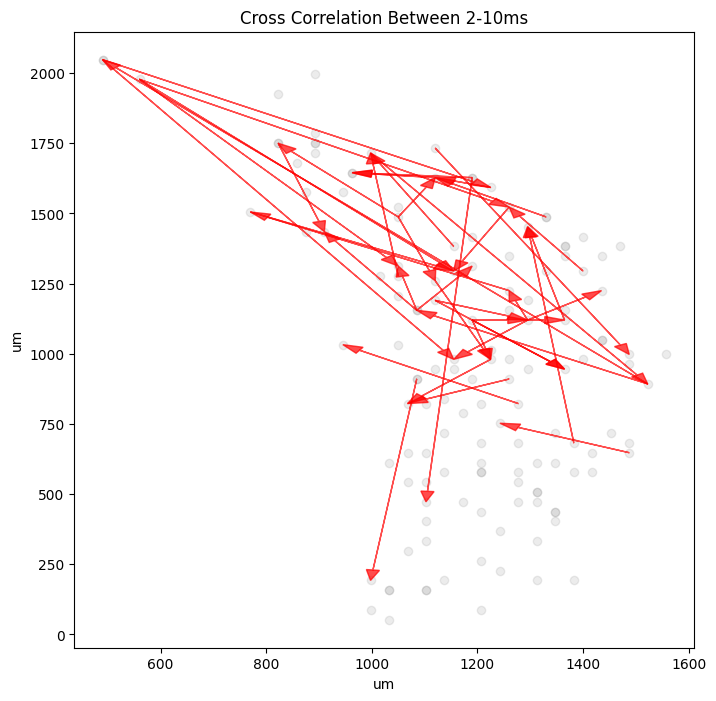

In [35]:
print(f"Delta: {delta}, Lag_Cutoff: {lag_cutoff}")
plotLagsLayout(sd, lags_corr, pairs_corr)


Delta: 20, Lag_Cutoff: 15


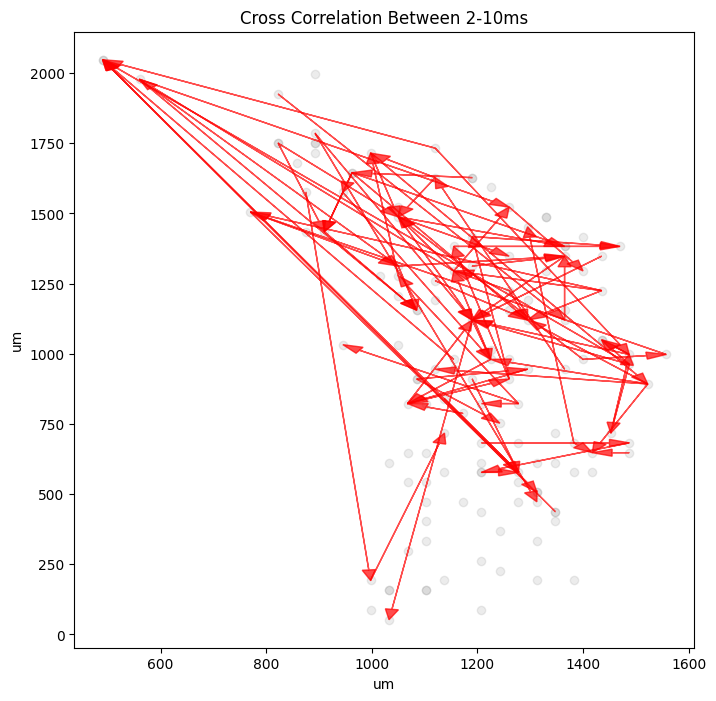

In [16]:
print(f"Delta: {delta}, Lag_Cutoff: {lag_cutoff}")
plotLagsLayout(sd, lags_corr, pairs_corr)

Delta: 10, Lag_Cutoff: 10


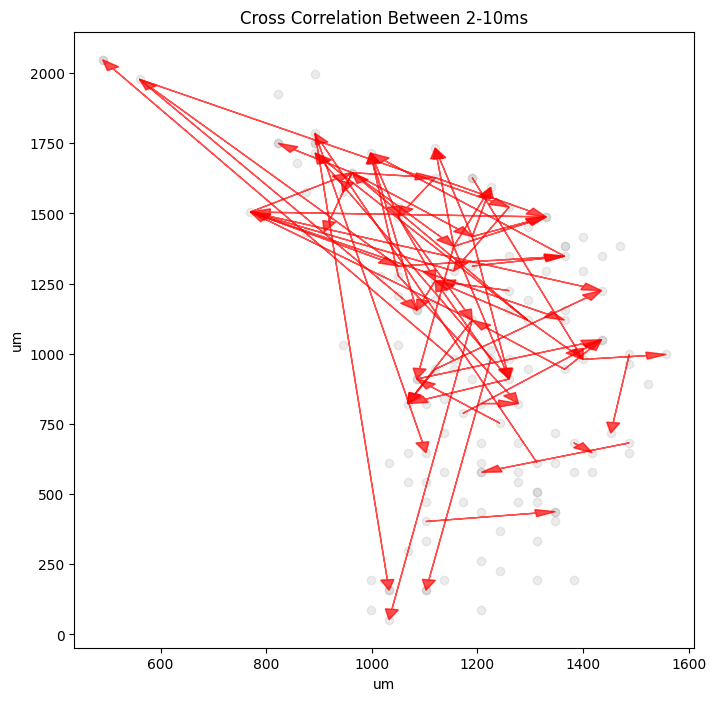

In [80]:
print(f"Delta: {delta}, Lag_Cutoff: {lag_cutoff}")
plotLagsLayout(sd, lags_corr, pairs_corr)

In [ ]:
print(f"Delta: {delta}, Lag_Cutoff: {lag_cutoff}")
plotLagsLayout(sd, lags_corr, pairs_corr)

In [ ]:
print(f"Delta: {delta}, Lag_Cutoff: {lag_cutoff}")
plotLagsLayout(sd, lags_corr, pairs_corr)


## Analyze STTC

 crossSTTC values

In [ ]:
@interact_manual
def showSttcs(num=(0,len(sttcs_corr)-1)):
    plt.plot( sttcs_corr[num] )

In [ ]:
#lags_corr
#pairs_corr

get lags to all be positive, switch pairs accordingly

In [ ]:
for i in np.where( lags_corr <0 )[0]:
    pairs_corr[i] =  [ pairs_corr[i][1], pairs_corr[i][0] ]
lags_corr = np.abs(lags_corr)

plot latency analysis for single pair

In [ ]:
@interact_manual(num=(0,len(pairs_corr)-1))
def analyzePair(num):
    plotPairAnalysis( pairs_corr[num][0], pairs_corr[num][1], sd)

# Analyze Instant Firing Rate

calculate all cross correlations

In [115]:
smoothing = 30
max_isi = 0.035

In [116]:
lags_ifr = []
count = 0
for pair in pairs:
    count +=1 
    if count%100 ==0:
        print(count)
    instant_n1 = movingAverage( instantFiringRate( sd, pair[0], max_isi= max_isi), smoothing) #,max_isi=0.1) , 12)
    instant_n2 = movingAverage( instantFiringRate( sd, pair[1], max_isi= max_isi), smoothing) #,max_isi=0.1) , 12)
    lags_ifr.append( maxCorrelationShift( instant_n1, instant_n2 ) )

100
200
300


Get all correlations between 2-10ms

In [117]:
lag_cutoff = 15
to_keep = np.where((np.abs(lags_ifr)< lag_cutoff) & (np.abs(lags_ifr)> 1) & (lags_ifr!=0) )[0]
len(to_keep)

36

In [118]:
pairs_ifr = np.array(pairs)[ to_keep ] 
lags_ifr = np.array(lags_ifr)[to_keep]

max_isi: 0.035, Smoothing: 30, Lag_Cutoff: 15


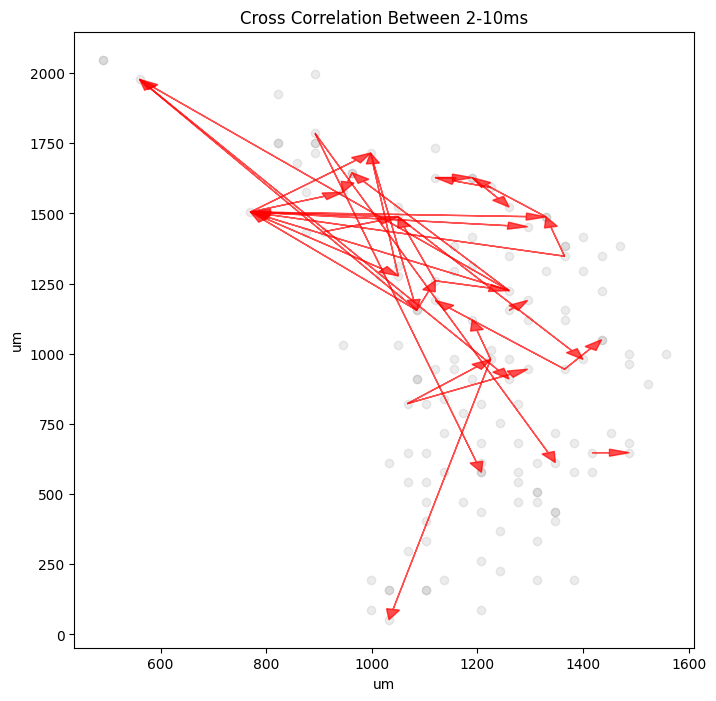

In [120]:
#print(f"Delta: 30, Lag_Cutoff: 10")
print(f"max_isi: {max_isi}, Smoothing: {smoothing}, Lag_Cutoff: {lag_cutoff}")
plotLagsLayout(sd, lags_ifr, pairs_ifr)

make all lags positive, switch values in pair when needed

In [121]:
for i in np.where( lags_ifr <0 )[0]:
    pairs_ifr[i] =  [ pairs_ifr[i][1], pairs_ifr[i][0] ]
lags_corr = np.abs(lags_ifr)

Analyze latencies

In [123]:
@interact_manual(num=(0,len(pairs_ifr)-1))
def analyzePair(num):
    plotPairAnalysis( pairs_ifr[num][0], pairs_ifr[num][1], sd)

interactive(children=(IntSlider(value=17, description='num', max=35), Button(description='Run Interact', style…

# Create Direction Raster

Create a pickle file of each time an arrow "fires"

In [87]:
latency_times = {}
for pair in pairs_corr:
    #latency_times[ (pair[0],pair[1]) ] = getLatencyTimes( pair[0], pair[1], sd, ms_cutoff=15, directed=False)
    latency_times[ (pair[0],pair[1]) ] =  getLatencyTimes( pair[0], pair[1], sd, ms_cutoff=15, directed=True )

In [88]:
file = open('/home/jovyan/work/Human_Hippocampus/2023_04_02_directed_latency_times_3.pkl', 'wb')
pickle.dump(latency_times, file)
file.close()


In [34]:
#latency_times

{(0,
  1): array([  2414.65,  19076.05,  19724.8 ,  24450.55,  25065.4 ,  25552.45,
         25775.45,  42421.5 ,  42461.45,  46608.7 ,  57111.5 ,  57495.7 ,
         78883.65,  83958.55,  84205.4 ,  85694.25,  89732.2 ,  97890.4 ,
        100781.55, 101212.35, 103063.45, 103196.1 , 105328.4 , 107400.25,
        108520.9 , 110621.1 , 112094.55, 112254.05, 117964.55, 118491.1 ,
        122040.35, 122658.4 , 122716.95, 125142.55, 125560.75, 129700.35,
        130041.45, 132366.  , 132935.5 , 134125.2 , 137563.25, 138486.4 ,
        141534.65, 142580.7 , 143319.75, 148542.4 , 149791.9 , 153508.7 ,
        154044.65, 157244.55, 160320.6 , 160778.65, 164581.8 , 165502.6 ,
        167053.3 , 167093.2 , 170508.05, 171020.75, 172312.8 , 185571.7 ,
        186287.9 , 188262.  , 188578.6 , 189174.65, 192442.65, 195522.55,
        201414.25, 203483.3 , 204426.95, 206272.5 , 206864.6 , 208935.05,
        212007.85, 212591.15, 213647.25, 217212.45, 219805.5 , 220097.7 ,
        227016.3 , 229124.5 

# <font color="brown">Safety Code